## Preliminary data analysis for Milestone 2 (ALEX)
### Dataset: Beer reviews

### Understand data structure inside datasets
(From referenced paper in google sheets)

- Five stars / five-aspect rating system: **feel, look, smell, taste & overall**
- BA: 33 387 users, 66 051 beers, 1 586 259 reviews
- RB: 40 213 users, 110 419 beers, 2 924 127 reviews

'ba' system | 'rb' system
:----------:|:-----------:
![](../data/img/ba_rating_system.png) | ![](../data/img/rb_rating_system.png)

For both systems: 'rating' column (final score) is automatically generated based on the five aspects


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import utils.data_utils as data_utils
import sqlite3 as sql
importlib.reload(data_utils)

DATA_FOLDER = '../local_data/'


Load the needed datasets

In [ ]:
m_beers_raw = pd.read_csv(DATA_FOLDER + 'merged/beers.csv', sep=',', header=[0, 1])
m_breweries_raw = pd.read_csv(DATA_FOLDER + 'merged/breweries.csv', sep=',', header=[0, 1])
m_ratings_raw = pd.read_csv(DATA_FOLDER + 'merged/ratings.csv', sep=',', header=[0, 1])

# # BA datasets
ba_users_raw = pd.read_csv(DATA_FOLDER + 'ba/users.csv', sep=',', header=[0])
ba_ratings_raw = data_utils.load_dict_like_text_file(DATA_FOLDER+'merged/ratings_with_text_ba.txt',BLK_SIZE=20_000, MAX_BLK=1_000_000)
print("Size of 'ba' ratings dataframe: %d" % ba_ratings_raw.index.size)

# # RB datasets
rb_users_raw = pd.read_csv(DATA_FOLDER + 'rb/users.csv', sep=',', header=[0])
rb_ratings_raw = data_utils.load_dict_like_text_file(DATA_FOLDER+'merged/ratings_with_text_rb.txt',BLK_SIZE=20_000, MAX_BLK=3_000_000)
print("Size of 'rb' ratings dataframe: %d" % rb_ratings_raw.index.size)


LOADED 'ratings_with_text_ba.txt'                         
Size of 'ba' ratings dataframe: 289011
LOADED 'ratings_with_text_rb.txt'                         
Size of 'rb' ratings dataframe: 1020548


Create a dataframe to show the available columns in the datasets

In [4]:
col_info = pd.DataFrame({'ba_ratings_text': pd.Series(ba_ratings_raw.columns),
            'rb_ratings_text': pd.Series(rb_ratings_raw.columns),
            'beers_ba': pd.Series(m_beers_raw['ba'].columns.unique()),
            'beers_rb': pd.Series(m_beers_raw['rb'].columns.unique()),
            'breweries': pd.Series(m_breweries_raw['ba'].columns.unique()),
            'users_ba': pd.Series(ba_users_raw.columns.unique()),
            'users_rb': pd.Series(rb_users_raw.columns.unique()),
            'matched_ratings_ba': pd.Series(m_ratings_raw['ba'].columns.unique()),
            'matched_ratings_rb': pd.Series(m_ratings_raw['rb'].columns.unique())})
col_info

,ba_ratings_text,rb_ratings_text,beers_ba,beers_rb,breweries,users_ba,users_rb,matched_ratings_ba,matched_ratings_rb
0,beer_name,beer_name,abv,abv,id,nbr_ratings,nbr_ratings,abv,abv
1,beer_id,beer_id,avg,avg,location,nbr_reviews,user_id,appearance,appearance
2,brewery_name,brewery_name,avg_computed,avg_computed,name,user_id,user_name,aroma,aroma
3,brewery_id,brewery_id,avg_matched_valid_ratings,avg_matched_valid_ratings,nbr_beers,user_name,joined,beer_id,beer_id
4,style,style,ba_score,beer_id,NaN,joined,location,beer_name,beer_name
5,abv,abv,beer_id,beer_name,NaN,location,NaN,brewery_id,brewery_id
6,date,date,beer_name,beer_wout_brewery_name,NaN,NaN,NaN,brewery_name,brewery_name
7,user_name,user_name,beer_wout_brewery_name,brewery_id,NaN,NaN,NaN,date,date
8,user_id,user_id,brewery_id,brewery_name,NaN,NaN,NaN,overall,overall
9,appearance,appearance,brewery_name,nbr_matched_valid_ratings,NaN,NaN,NaN,palate,palate


## Creating a personalized dataset
Analyzing and merging the reviews with text from 'ba' and 'rb' datasets for maxizing the number of ratings to be used in our analysis

In [18]:
# Only different column from rb and ba is the 'review'
# Let's dive in to see what it contains
print("------ Values of this mysterious 'review' column -------")

display(ba_ratings_raw['review'].value_counts())

print("Interesting, some of the review values are false. What does it mean? Verifying if some of the values are NaN:")
display(ba_ratings_raw[ba_ratings_raw.review == 'False'].isna().sum())
print("None of the columns contains NaN values. CONCLUSION: DROP this useless column!\n")

ba_ratings = ba_ratings_raw.copy()
rb_ratings = rb_ratings_raw.copy()
ba_ratings.drop('review', axis=1, inplace=True)
print("----- Adjusted columns for ba and rb ratings -------")
display(pd.DataFrame([ba_ratings.columns, rb_ratings_raw.columns]))


------ Values of this mysterious 'review' column -------


review
True     272814
False     16197
Name: count, dtype: int64

Interesting, some of the review values are false. What does it mean? Verifying if some of the values are NaN:


beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
abv             0
date            0
user_name       0
user_id         0
appearance      0
aroma           0
palate          0
taste           0
overall         0
rating          0
text            0
review          0
dtype: int64

None of the columns contains NaN values. CONCLUSION: DROP this useless column!

----- Adjusted columns for ba and rb ratings -------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
1,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text


---

### A. Merge rb and ba ratings with text in a single dataframe

**Before** merging, normalize all score data to have same basis (Some are over /5 /10 or even /20)!

In [19]:
# Limit floating point decimals output
pd.options.display.float_format = '{:.2f}'.format

# Perform normalization of data
# First, adjust data types to float for ratings
cols = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
rb_ratings[cols] = rb_ratings[cols].astype(float)
ba_ratings[cols] = ba_ratings[cols].astype(float)

print("------ RB Stats (before normalization) -------")
display(rb_ratings.describe())
print("------ BA Stats (before normalization) -------")
display(ba_ratings.describe())

# Second, normalize all scores /5 (Only 'overall', 'taste', 'aroma' are different)
rb_ratings['overall'] = rb_ratings['overall'] / 4
rb_ratings[['taste', 'aroma']] = rb_ratings[['taste', 'aroma']] / 2

print("------ RB Stats (after normalization) -------")
display(rb_ratings.describe())
print("------ BA Stats (after normalization) -------")
display(ba_ratings.describe())

# Join rb and ba users dataframe to have access to location
rb_ratings.loc[:, 'user_id'] = rb_ratings.loc[:, 'user_id'].astype(int)
rb_ratings.drop(columns=['user_name'], inplace=True)
ba_ratings.loc[:, 'user_id'] = ba_ratings.loc[:, 'user_id'].astype(str)
ba_ratings.drop(columns=['user_name'], inplace=True)
ba_users_raw.loc[:, 'user_id'] = ba_users_raw.loc[:, 'user_id'].astype(str)
rb_user_ratings = rb_ratings.join(other=rb_users_raw.set_index('user_id'), on='user_id', how='left')
ba_user_ratings = ba_ratings.join(other=ba_users_raw.set_index('user_id'), on='user_id', how='left')
rb_user_ratings.rename(columns={'location': 'location_user'}, inplace=True)
ba_user_ratings.rename(columns={'location': 'location_user'}, inplace=True)

# Join brewery also to have access to location
rb_breweries = m_breweries_raw['rb']
rb_breweries.loc[:, 'id'] = rb_breweries.loc[:, 'id'].astype(int)
rb_user_ratings.loc[:, 'brewery_id'] = rb_user_ratings.loc[:, 'brewery_id'].astype(int)
ba_breweries = m_breweries_raw['ba']
ba_breweries.loc[:,'id'] = ba_breweries.loc[:,'id'].astype(int)
ba_user_ratings.loc[:,'brewery_id'] = ba_user_ratings.loc[:,'brewery_id'].astype(int)
rb_combined_ratings = rb_user_ratings.join(other=rb_breweries.set_index('id'), on='brewery_id', how='left')
ba_combined_ratings = ba_user_ratings.join(other=ba_breweries.set_index('id'), on='brewery_id', how='left')
rb_combined_ratings.rename(columns={'location': 'location_brewery'}, inplace=True)
ba_combined_ratings.rename(columns={'location': 'location_brewery'}, inplace=True)

print("------ RB user matched df -------")
display(rb_combined_ratings.sample(2))
print("------ BA user matched df -------")
display(ba_combined_ratings.sample(2))

# Merge rb and ba with text reviews in a single dataframe
rb_combined_ratings['source'] = 'rb'
ba_combined_ratings['source'] = 'ba'

print("------ Merged dataset with adjusted ratings scores -------")
df_text_ratings = pd.concat([ba_combined_ratings, rb_combined_ratings], axis=0)
df_text_ratings.sample(5)

------ RB Stats (before normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00
mean,3.50,6.66,3.37,6.72,13.70,3.40
std,0.72,1.33,0.74,1.34,2.70,0.58
min,1.00,1.00,1.00,1.00,1.00,0.50
25%,3.00,6.00,3.00,6.00,12.00,3.10
50%,3.00,7.00,3.00,7.00,14.00,3.50
75%,4.00,7.00,4.00,8.00,15.00,3.80
max,5.00,10.00,5.00,10.00,20.00,5.00


------ BA Stats (before normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,283857.00,283857.00,283857.00,283857.00,283857.00,289011.00
mean,3.91,3.83,3.83,3.86,3.87,3.86
std,0.55,0.61,0.61,0.65,0.63,0.56
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50,3.57
50%,4.00,4.00,4.00,4.00,4.00,3.93
75%,4.25,4.25,4.25,4.25,4.25,4.22
max,5.00,5.00,5.00,5.00,5.00,5.00


------ RB Stats (after normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00
mean,3.50,3.33,3.37,3.36,3.42,3.40
std,0.72,0.67,0.74,0.67,0.67,0.58
min,1.00,0.50,1.00,0.50,0.25,0.50
25%,3.00,3.00,3.00,3.00,3.00,3.10
50%,3.00,3.50,3.00,3.50,3.50,3.50
75%,4.00,3.50,4.00,4.00,3.75,3.80
max,5.00,5.00,5.00,5.00,5.00,5.00


------ BA Stats (after normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,283857.00,283857.00,283857.00,283857.00,283857.00,289011.00
mean,3.91,3.83,3.83,3.86,3.87,3.86
std,0.55,0.61,0.61,0.65,0.63,0.56
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50,3.57
50%,4.00,4.00,4.00,4.00,4.00,3.93
75%,4.25,4.25,4.25,4.25,4.25,4.22
max,5.00,5.00,5.00,5.00,5.00,5.00


------ RB user matched df -------


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_id,appearance,aroma,...,overall,rating,text,nbr_ratings,user_name,joined,location_user,location_brewery,name,nbr_beers
514638,Aspen Silver City,448841,Aspen Brewing Company,9776,Sour/Wild Ale,4.3,1475834400,24296,3.00,3.50,...,3.00,3.10,Can. Pours a clear yellow body with a small fi...,5924.00,kramer,1121421600.00,"United States, Pennsylvania","United States, Colorado",Aspen Brewing Company,27
708597,Jolly Pumpkin Maracaibo Especial,43153,Jolly Pumpkin Artisan Ales,4923,Belgian Strong Ale,7.5,1160647200,22192,5.00,4.00,...,4.00,4.10,"Aroma cocoa, cinnamon, plummy fruits, pommegra...",2630.00,puzzl,1115805600.00,"United States, New York","United States, Michigan",Jolly Pumpkin Artisan Ales,150


------ BA user matched df -------


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_id,appearance,aroma,...,rating,text,nbr_ratings,nbr_reviews,user_name,joined,location_user,location_brewery,name,nbr_beers
144384,Riserva,43217,Weyerbacher Brewing Co.,392,American Wild Ale,11.4,1370080800,mddmd.602350,4.00,4.25,...,4.16,A-minimally hazy red amber color with a smalli...,2115,1115,MDDMD,1307181600.00,"United States, Pennsylvania","United States, Pennsylvania",Weyerbacher Brewing Co.,184
44599,Wheat Monkey,50649,"Lakefront Brewery, Inc.",741,American Pale Wheat Ale,4.2,1339236000,florida9.298439,3.00,3.50,...,3.12,A Very pale pastel yellow in color. Cloudy. Ba...,1702,1498,Florida9,1234609200.00,"United States, Illinois","United States, Wisconsin","Lakefront Brewery, Inc.",115


------ Merged dataset with adjusted ratings scores -------


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_id,appearance,aroma,...,text,nbr_ratings,nbr_reviews,user_name,joined,location_user,location_brewery,name,nbr_beers,source
249118,India Pale Ale,65038,Westbrook Brewing Co.,24134,American IPA,6.8,1371204000,cosmicevan.404079,4.00,4.50,...,New craft bar opened 5 minutes from my house t...,2412.00,2367.00,cosmicevan,1260702000.00,"United States, New York","United States, South Carolina",Westbrook Brewing Co.,189,ba
923506,De Bie Blonde Bie,42018,Brouwerij de Bie,1226,Belgian Strong Ale,8.0,1262775600,83882,3.00,3.00,...,"Cloudy, murky dull orange color with a small w...",22799.00,NaN,Travlr,1227697200.00,"United States, North Carolina",Belgium,Brouwerij de Bie,14,rb
205667,Allagash Four,16655,Allagash Brewing Company,4,Quadrupel (Quad),10.0,1244887200,colts9016.145888,3.00,4.00,...,"Got this bottle from mike, thank youPoured int...",968.00,955.00,colts9016,1183370400.00,"United States, Nevada","United States, Maine",Allagash Brewing Company,150,ba
174031,Saison Du Clifton,94122,Country Boy Brewing,28188,Saison / Farmhouse Ale,7.6,1370253600,mrfrancis.489156,3.50,3.50,...,A Pours a cloudy gold with a thin white mousse...,2292.00,766.00,mrfrancis,1281261600.00,"United States, Kentucky","United States, Kentucky",Country Boy Brewing,158,ba
461975,Triplehorn Runestone Porter,220928,Triplehorn Brewing Company,14957,Porter,6.4,1373796000,32533,4.00,3.50,...,Draft at sb. Pours jet black with a dense and ...,6883.00,NaN,after4ever,1137927600.00,"United States, Washington","United States, Washington",Triplehorn Brewing Company,43,rb


---

### B. Removing duplicate reviews
Some users have the same (but different) ratings (and text review) on both rb and ba websites. After analysis of the "matched ratings" dataset, only the reviews matched for rb will be kept due to missing text reviews and ratings for the BA website.

In [20]:
m_ratings_ba = m_ratings_raw['ba']
df_text_ratings_no_duplicates = df_text_ratings.reset_index()
# Making sure user_id is of type str
m_ratings_ba.loc[:,'user_id'] = m_ratings_ba.loc[:,'user_id'].astype("string")
m_ratings_ba.loc[:,'beer_id'] = m_ratings_ba.loc[:,'beer_id'].astype(int)
df_text_ratings_no_duplicates.loc[:,'user_id'] = df_text_ratings_no_duplicates.loc[:,'user_id'].astype("string")
df_text_ratings_no_duplicates.loc[:,'beer_id'] = df_text_ratings_no_duplicates.loc[:,'beer_id'].astype(int)

count_before = df_text_ratings_no_duplicates.index.size
print("Total # of combined ratings before filtering: {0}".format(count_before))
print("Total # of duplicate ratings to remove: {0}".format(m_ratings_ba.index.size))

idx_to_drop = df_text_ratings_no_duplicates.join(m_ratings_ba.set_index(['user_id', 'beer_id']), on=['user_id','beer_id'], lsuffix='_left', how='inner').index
df_text_ratings_no_duplicates.drop(index=idx_to_drop, inplace=True)

count_after = df_text_ratings_no_duplicates.index.size
print("Total # of combined ratings after filtering: {0} --> Difference: {1}".format(count_after, count_before-count_after))

Total # of combined ratings before filtering: 1318764
Total # of duplicate ratings to remove: 21964
Total # of combined ratings after filtering: 1300486 --> Difference: 18278


#### Cleanup dataset by removing unused columns and casting to right dataypes

In [21]:
# Dropping unused columns: [beer_id, brewery_id, user_id, nbr_ratings, nbr_reviews, joined, nbr_beers]
df_ratings_cleaned = df_text_ratings_no_duplicates.copy()
df_ratings_cleaned.drop(columns=['beer_id', 'brewery_id', 'user_id', 'nbr_ratings', 'nbr_reviews', 'joined', 'nbr_beers'], inplace=True)

# Adjusting ambiguous column names
df_ratings_cleaned.rename(columns={'name': 'brewery_name'}, inplace=True)
df_ratings_cleaned.drop(columns=['index'], inplace=True)

# Casting to 'human readable' dates
df_ratings_cleaned['date'] = df_ratings_cleaned['date'].astype(int)
df_ratings_cleaned['date'] = pd.to_datetime(df_ratings_cleaned['date'], unit='s')

# string columns
cols = ['beer_name', 'brewery_name', 'style', 'user_name', 'location_user', 'location_brewery', 'text', 'source']
for c in cols:
    df_ratings_cleaned[c] = df_ratings_cleaned[c].astype(str)
# float columns
df_ratings_cleaned['abv'] = df_ratings_cleaned['abv'].astype(float)

print("!--- Datatypes verification -------")
display(df_ratings_cleaned.dtypes)
df_ratings_cleaned.sample(5)

!--- Datatypes verification -------


beer_name                   object
brewery_name                object
style                       object
abv                        float64
date                datetime64[ns]
appearance                 float64
aroma                      float64
palate                     float64
taste                      float64
overall                    float64
rating                     float64
text                        object
user_name                   object
location_user               object
location_brewery            object
brewery_name                object
source                      object
dtype: object

,beer_name,brewery_name,style,abv,date,appearance,aroma,palate,taste,overall,rating,text,user_name,location_user,location_brewery,brewery_name,source
467659,Barre Maibock,Privatbrauerei Ernst Barre,Heller Bock,6.90,2017-05-29 10:00:00,4.00,3.00,3.00,3.00,2.75,3.00,Bottle. Clear dark golden wirth a short-lived ...,Grumpelmies,Germany,Germany,Privatbrauerei Ernst Barre,rb
170419,Blakkr,Surly Brewing Co. Beer Hall,American Black Ale,9.99,2014-03-19 11:00:00,4.00,4.00,3.50,4.00,3.75,3.90,Heard about this brew from Fox and Chim. Thank...,stumac,"United States, Texas","United States, Minnesota",Surly Brewing Company,ba
876279,Big Sky Montana Trout Slayer Ale,Big Sky Brewing Company,Wheat Ale,5.00,2008-05-24 10:00:00,4.00,2.00,5.00,3.50,2.25,2.90,Tap in West Yellowstone. Pour was a clear gol...,topherh,"United States, Missouri","United States, Montana",Big Sky Brewing Company,rb
894953,Perennial Peace Offering,Perennial Artisan Ales,Spice/Herb/Vegetable,6.30,2013-10-25 10:00:00,4.00,3.50,3.00,3.50,3.50,3.50,(750ml bottle) Pours a burnt orange body with ...,bu11zeye,"United States, Texas","United States, Missouri",Perennial Artisan Ales,rb
1317500,Vaat Witty Nelson,Vaat,Witbier,5.50,2017-02-07 11:00:00,3.00,1.50,3.00,1.50,2.00,2.00,Thank you for sharing kraddel + tderock + Rubi...,77ships,Belgium,Estonia,Vaat,rb


----

### C. Final step: transform the following columns : [country, style, beer] for easier usage of data

Some pre-filtering is needed to match style and beers that are really close together

1. Check out location values under users

In [22]:
display(df_ratings_cleaned['location_user'].value_counts()[:10])

# Lets check out the ones  with a commma (,)
display(df_ratings_cleaned[df_ratings_cleaned['location_user'].apply(lambda x: ',' in x)].loc[:,'location_user'].unique())

# Separate States and Country (add state column, filled with N.A. if no state)
df_ratings_cleaned['country_user'] = df_ratings_cleaned['location_user'].apply(lambda x: x.split(',')[0] if len(x.split(',')) > 0 else x)
df_ratings_cleaned['country_brewery'] = df_ratings_cleaned['location_brewery'].apply(lambda x: x.split(',')[0] if len(x.split(',')) > 0 else x)
df_ratings_cleaned['state_user'] = df_ratings_cleaned['location_user'].apply(lambda x: ''.join(x.split(',')[1:]) if len(x.split(',')) > 0 else None)
df_ratings_cleaned['state_brewery'] = df_ratings_cleaned['location_brewery'].apply(lambda x: ''.join(x.split(',')[1:]) if len(x.split(',')) > 0 else None)

display(df_ratings_cleaned['country_user'].value_counts())
display(df_ratings_cleaned['state_user'].value_counts())

location_user
Canada                         100011
Denmark                         76422
United States, California       67098
England                         62178
Sweden                          52288
United States, Pennsylvania     49853
Netherlands                     42034
nan                             40108
United States, Illinois         39576
United States, New York         38626
Name: count, dtype: int64

array(['United States, North Carolina', 'United States, New York',
       'United States, Illinois', 'United States, Massachusetts',
       'United States, Virginia', 'United States, South Carolina',
       'United States, Georgia', 'United States, West Virginia',
       'United States, Pennsylvania', 'United States, Alabama',
       'United States, Indiana', 'United States, Rhode Island',
       'United States, Missouri', 'United States, Arkansas',
       'United States, Louisiana', 'United States, Ohio',
       'United States, Connecticut', 'United States, Florida',
       'United States, Minnesota', 'United States, New Jersey',
       'United States, Maryland', 'United States, Alaska',
       'United States, Mississippi', 'United States, Kentucky',
       'United States, Oklahoma', 'United States, New Hampshire',
       'United States, California', 'United States, Washington',
       'United States, Wisconsin', 'United States, Oregon',
       'United States, New Mexico', 'United Sta

country_user
United States                     666554
Canada                            100011
Denmark                            76422
England                            62178
Sweden                             52288
                                   ...  
British Indian Ocean Territory         1
Armenia                                1
Nepal                                  1
Abkhazia                               1
Kenya                                  1
Name: count, Length: 136, dtype: int64

state_user
                   633932
 California         67098
 Pennsylvania       49853
 Illinois           39576
 New York           38626
 Texas              32140
 Washington         28929
 Ohio               28625
 New Jersey         27647
 Florida            26433
 Minnesota          24142
 Colorado           24103
 Virginia           23520
 Massachusetts      23290
 North Carolina     18906
 Michigan           15992
 Wisconsin          15837
 Georgia            15530
 Maryland           15152
 Oregon             13906
 Indiana            12814
 Arizona            11602
 Missouri           10423
 Tennessee           9301
 Connecticut         9077
 New Hampshire       8824
 Kentucky            7695
 Iowa                7180
 Idaho               6439
 Vermont             5541
 Nevada              4617
 Alabama             4503
 South Carolina      4359
 Kansas              3974
 Maine               3807
 Louisiana           3008
 Nebraska            2931
 Rhode Island        2705
 

2. Style of the beer

In [23]:
print("There is {0} styles of beer registered in the dataset".format(df_ratings_cleaned['style'].unique().size))
display(df_ratings_cleaned['style'].unique())

# Using ChatGPT to "cluster" and identify some generic categories for a pre-filtering of the styles
category_map = data_utils.get_beer_style_mapping()
df_ratings_cleaned['style_category'] = df_ratings_cleaned['style'].map(category_map).fillna('Other')

df_ratings_cleaned['style_category'].value_counts()

There is 169 styles of beer registered in the dataset


array(['English Pale Ale', 'English Bitter', 'American Pale Wheat Ale',
       'American Double / Imperial Stout', 'Hefeweizen', 'American IPA',
       'English Porter', 'English India Pale Ale (IPA)',
       'German Pilsener', 'Kölsch', 'American Black Ale', 'Oatmeal Stout',
       'American Pale Ale (APA)', 'American Amber / Red Ale',
       'Milk / Sweet Stout', 'Saison / Farmhouse Ale',
       'Russian Imperial Stout', 'Tripel',
       'American Double / Imperial IPA', 'American Wild Ale',
       'English Stout', 'American Stout', 'Fruit / Vegetable Beer',
       'American Blonde Ale', 'Belgian Strong Pale Ale',
       'English Strong Ale', 'Old Ale',
       'Extra Special / Strong Bitter (ESB)', 'Witbier',
       'Herbed / Spiced Beer', 'English Dark Mild Ale', 'Czech Pilsener',
       'English Pale Mild Ale', 'English Brown Ale', 'Irish Red Ale',
       'Scottish Ale', 'Winter Warmer', 'Berliner Weissbier', 'Gose',
       'American Brown Ale', 'Scotch Ale / Wee Heavy', 'Euro Pale

style_category
India Pale Ale (IPA)    246235
Other                   225541
Pale Ale                148363
Belgian Ale             108842
Sour Ale                 81660
Specialty & Seasonal     65628
Stout                    64060
Saison & Farmhouse       62268
Strong Ale               52237
Lager                    44838
Wheat Beer               41225
Strong Lager             30679
Pilsner                  30341
Hybrid Styles            30101
Porter                   23644
Dark Lager               22004
Other Ales               20852
Low Alcohol               1968
Name: count, dtype: int64

3. Try to filter out same beers but written differently (upper/lower case, proposition added)

In [385]:
# TODO for milestone 3 (Maybe use tokens to identify same beer named slighlty different)

**EXPORT** the cleaned dataframe to CSV file

In [ ]:
OUTPUT_FOLDER = '../local_data/'

df_ratings_cleaned.to_csv(OUTPUT_FOLDER + 'cleaned_ratings.csv', sep=',', header=True)
print("Dataframe exported to '{0}'!".format(OUTPUT_FOLDER + 'cleaned_ratings.csv'))

---

### Investigating the created dataframe containing reviews of beers by countries and styles

1. Look at the yearly and monthly distribution of data (reviews)

> This gives a glance of how the reviews are spread over the years. The monthly bar plot is independant of the years (using all the reviews)


In [ ]:
# IF needed, load the cleaned dataset from .csv file
DATA_INPUT_FOLDER = "../local_data/"

df_ratings_cleaned = pd.read_csv(DATA_INPUT_FOLDER + "cleaned_dataset.csv", delimiter=',', header=[0])

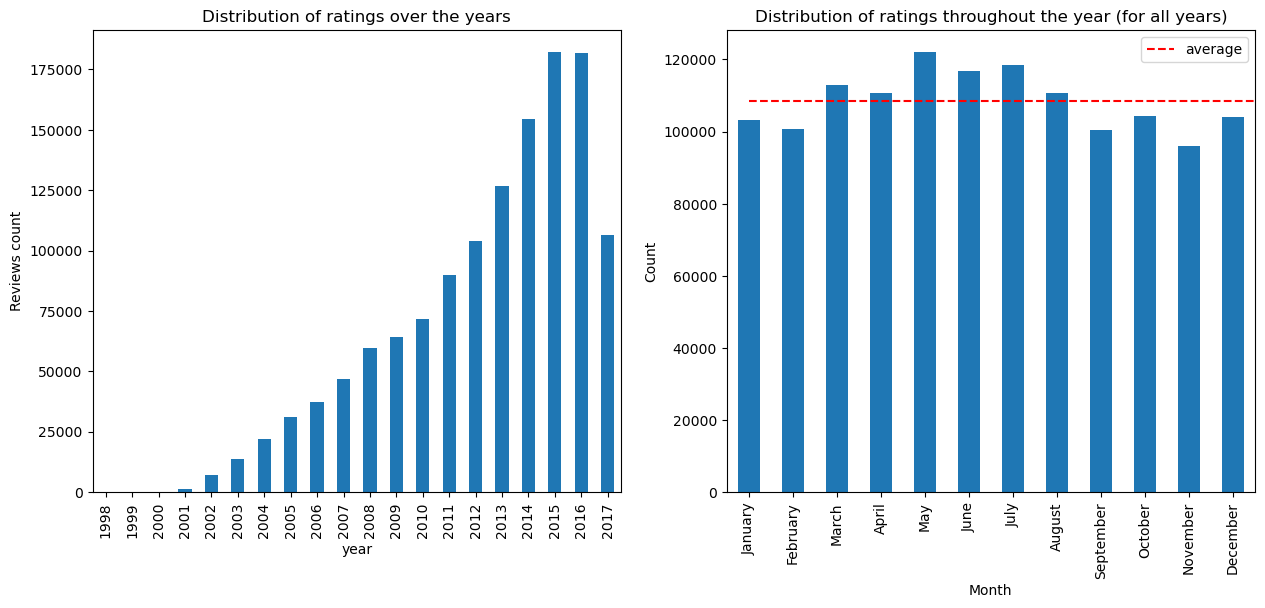

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.year).size().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribution of ratings over the years')
ax[0].set_xlabel('year')
ax[0].set_ylabel('Reviews count')
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().plot(kind='bar', ax=ax[1])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax[1].plot([0,12],[df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().apply('mean')]*2, color='red', linestyle='--', label='average')
ax[1].set_title('Distribution of ratings throughout the year (for all years)')
ax[1].set_xticklabels(months)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count')
ax[1].legend()
plt.show()

2. Distribution of ratings per style for a specefied country

> Here the goal is to provide quick insights of the distribution of the ratings for a selected country

Total # of ratings for Belgium: 22291


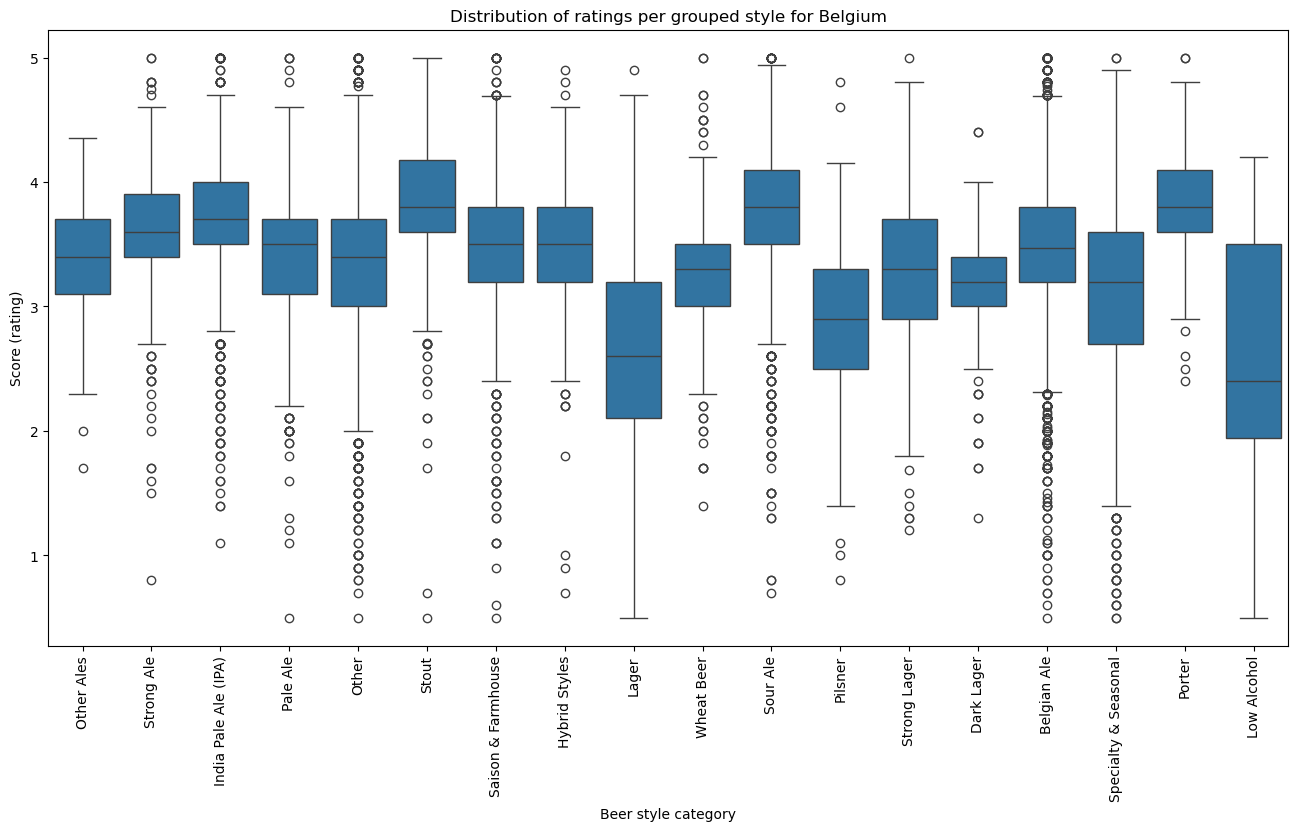

In [28]:
import seaborn as sns

country = 'Belgium'
cols = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

df_selected_country = df_ratings_cleaned[df_ratings_cleaned.country_user == country]

print("Total # of ratings for {0}: {1}".format(country, df_selected_country['rating'].count()))

plt.figure(figsize=(16,8))
sns.boxplot(x='style_category', y='rating', data=df_selected_country)
plt.xticks(rotation=90)
plt.title('Distribution of ratings per grouped style for {0}'.format(country))
plt.xlabel('Beer style category')
plt.ylabel('Score (rating)')
plt.show()

3. Look at best rated beer style per country

In [55]:
def get_top_n(df, group, column, n): 
    return df.groupby(group).mean().sort_values(by=column,ascending=False)[:n]

cols = ['rating', 'overall', 'palate', 'taste', 'appearance', 'aroma', 'style_category']
df_ratings_cleaned.groupby(['country_user'])[cols].apply(get_top_n, group='style_category', column='rating', n=1)[['rating', 'overall', 'palate', 'taste', 'appearance', 'aroma']]


,,rating,overall,palate,taste,appearance,aroma
country_user,style_category,,,,,,
Abkhazia,Other,4.80,5.00,5.00,4.00,5.00,5.00
Afghanistan,Strong Ale,4.40,4.75,5.00,4.00,4.00,4.00
Albania,Other,5.00,5.00,5.00,5.00,5.00,5.00
Algeria,Strong Lager,3.90,4.00,3.00,4.50,4.00,3.50
Andorra,Wheat Beer,4.69,4.75,4.75,4.75,4.75,4.50
...,...,...,...,...,...,...,...
Venezuela,Porter,3.75,4.00,3.50,3.75,3.00,3.75
Vietnam,India Pale Ale (IPA),4.25,4.25,4.25,4.25,4.25,4.25
Virgin Islands (U.S.),Lager,3.80,3.75,2.00,4.50,4.00,4.00


**TODOs**
- Look at users with a lot of reviews and try to look at the distribution of styles / # of different beers rated

In [57]:
ba_users_raw['location'].isna().sum() + rb_users_raw['location'].isna().sum()

50861